# Model Evaluation & Selection
**`Sentiment Analysis:` [M-BERT](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/blob/main/notebooks/5.1.1-modeling-mbert-sentiment-analysis.ipynb) | [BERTweet](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/blob/main/notebooks/5.1.2-modeling-bertweet-sentiment-analysis.ipynb) | [Twitter XLM-roBERTA](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/blob/main/notebooks/5.1.3-modeling-xlm-roberta-sentiment-analysis.ipynb)**

**`Goal:`** Compare the performance of the best checkpoints of the three different models (M-BERT, BERTweet, and Twitter XLM-roBERTA) on the validation and test sets to settle on a final model to be used for our prediction tasks

**`Results:`** As was evident from the notebooks, the **BERTweet** outperformed the XLM-roBERTa and the M-BERT models

## 1. Import packages

In [1]:
#Visualization packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

#Modeling and evaluation packages
import torch
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

#Metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

## 2. Load the sentiment analysis evaluation data

**Validation set**

In [2]:
#Load the validation set
validation_df = pd.read_csv("../data/model-evaluation/sentiment-analysis/validation_set.csv")

#Quick preview
validation_df.head()

,ISP_Name,Time,Text,Source,sentiment,label,split_group
0,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,0,validation_set
1,sprectranet,2020-02-13 16:41:58+00:00,therealmusty toolzo spectranet_ng baba today i...,Twitter for Android,Neutral,1,validation_set
2,sprectranet,2019-09-06 16:21:10,nothing as frustrating as terrible network and...,Twitter for iPhone,Negative,0,validation_set
3,sprectranet,2019-03-25 19:18:05,digitaltrends spectranet_ng how far? are we go...,Twitter for Android,Neutral,1,validation_set
4,sprectranet,2019-05-20 12:22:17,spectranet_ng hwfa? why so slow???,Twitter for Android,Negative,0,validation_set


**Test set**

In [3]:
#Load the test set
test_df = pd.read_csv("../data/model-evaluation/sentiment-analysis/test_set.csv")

#Quick preview
test_df.head()

,ISP_Name,Time,Text,Source,sentiment,label,split_group
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,1,test_set
1,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,1,test_set
2,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,0,test_set
3,sprectranet,2020-09-01 21:23:18+00:00,shawttynatt even glo and airtel. if not for sp...,Twitter for Android,Positive,2,test_set
4,sprectranet,2020-03-27 09:02:59+00:00,"dre81us wow, sorry about this. spectranet work...",Twitter for Android,Positive,2,test_set


## 3. Load the best checkpoints from the models
**`BERTweet` | `M-BERT` | `XLM-roBERTa-base`**

### a. Load tokenizers

In [4]:
#M-BERT tokenizer
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case= False)

#BERTweet tokenizer
bertweet_tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis", normalization=True)

#XLMR-roBERTa-base
xlmr_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

### b. Load models

In [5]:
#M-BERT model
mbert_model = BertForSequenceClassification.from_pretrained("../models/baseline-mbert/checkpoint-232")

#BERTweet model
bertweet_model = AutoModelForSequenceClassification.from_pretrained("../models/bertweet/baseline-bertweet/checkpoint-203")

#XLMR model
xlmr_model = AutoModelForSequenceClassification.from_pretrained("../models/xlmr-roberta/checkpoint-58")

## 4. Define function to prepare the datasets

In [6]:
class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    
    Class to encode a dataset for modeling using the model's corresponding tokenizer
    
    Inputs:
        - texts (pandas series): The text/tweets to be encoded
        - labels (pandas series): The (encoded) sentiment labels
        - tokenizer: The tokenizer to be applied for encoding
    
    Output:
        - Dictionary of elements from encoded representation
    
    ---------
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c
    ---------
    
    
    """

    def __init__(self, texts, labels, tokenizer, max_len = None):
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.max_len    = max_len if max_len else tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }


def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, macro-averaged f1 score, and accuracy
    #We use macro so we can better see the effect of the class imbalance i.e. treat all classes as equal
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    #accuracy = accuracy_score(labels, predictions)
    
    return {
        'F-1 score': f1,
        'precision': precision,
        'recall': recall,
        #'accuracy': accuracy
    }


### 5. Evaluate the models on the validation set

In [7]:
#List of the different models' components
model_dependencies = [['M-BERT',mbert_tokenizer,mbert_model],
                      ['BERTweet',bertweet_tokenizer,bertweet_model],
                      ['XLMR-roBERTa-base',xlmr_tokenizer,xlmr_model]]

#Dictionary to store the evaluation results
validation_results = {}

for model_name, tokenizer, model in model_dependencies:
    
    #Prepare the validation set
    val_set_dataset = Generate_PyTorch_Dataset(
        texts       = validation_df.Text.tolist(),
        labels      = validation_df.label.tolist(),
        tokenizer   = tokenizer,
        max_len     = 128 if model_name == 'XLMR-roBERTa-base' else None
    )
    
    #Define training arguments for prediction mode
    training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
    )

    #Define the predictor
    trainer = Trainer(
        model           = model,
        args            = training_args,
        compute_metrics = compute_metrics,
    )

    #Predict on the validation set
    preds = trainer.predict(val_set_dataset, metric_key_prefix='val')
    
    validation_results[model_name] = preds[-1]
    
    



***** Running Prediction *****
  Num examples = 76
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 76
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 76
  Batch size = 8


In [13]:
#Create a dataframe of the evaluation results
val_metrics = (pd.DataFrame(validation_results).T).iloc[:,:4].drop(columns=['val_loss']).reset_index().rename(columns={'index':'model'})

#Reformat names
val_metrics.columns = val_metrics.columns.str.replace('val_','val ').str.replace('_','-')

#Quick preview
val_metrics.head()

,model,val F-1 score,val precision,val recall
0,M-BERT,0.518227,0.598323,0.499713
1,BERTweet,0.829649,0.819307,0.843956
2,XLMR-roBERTa-base,0.770091,0.873432,0.723658


#### • Plot the evaluation metrics

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


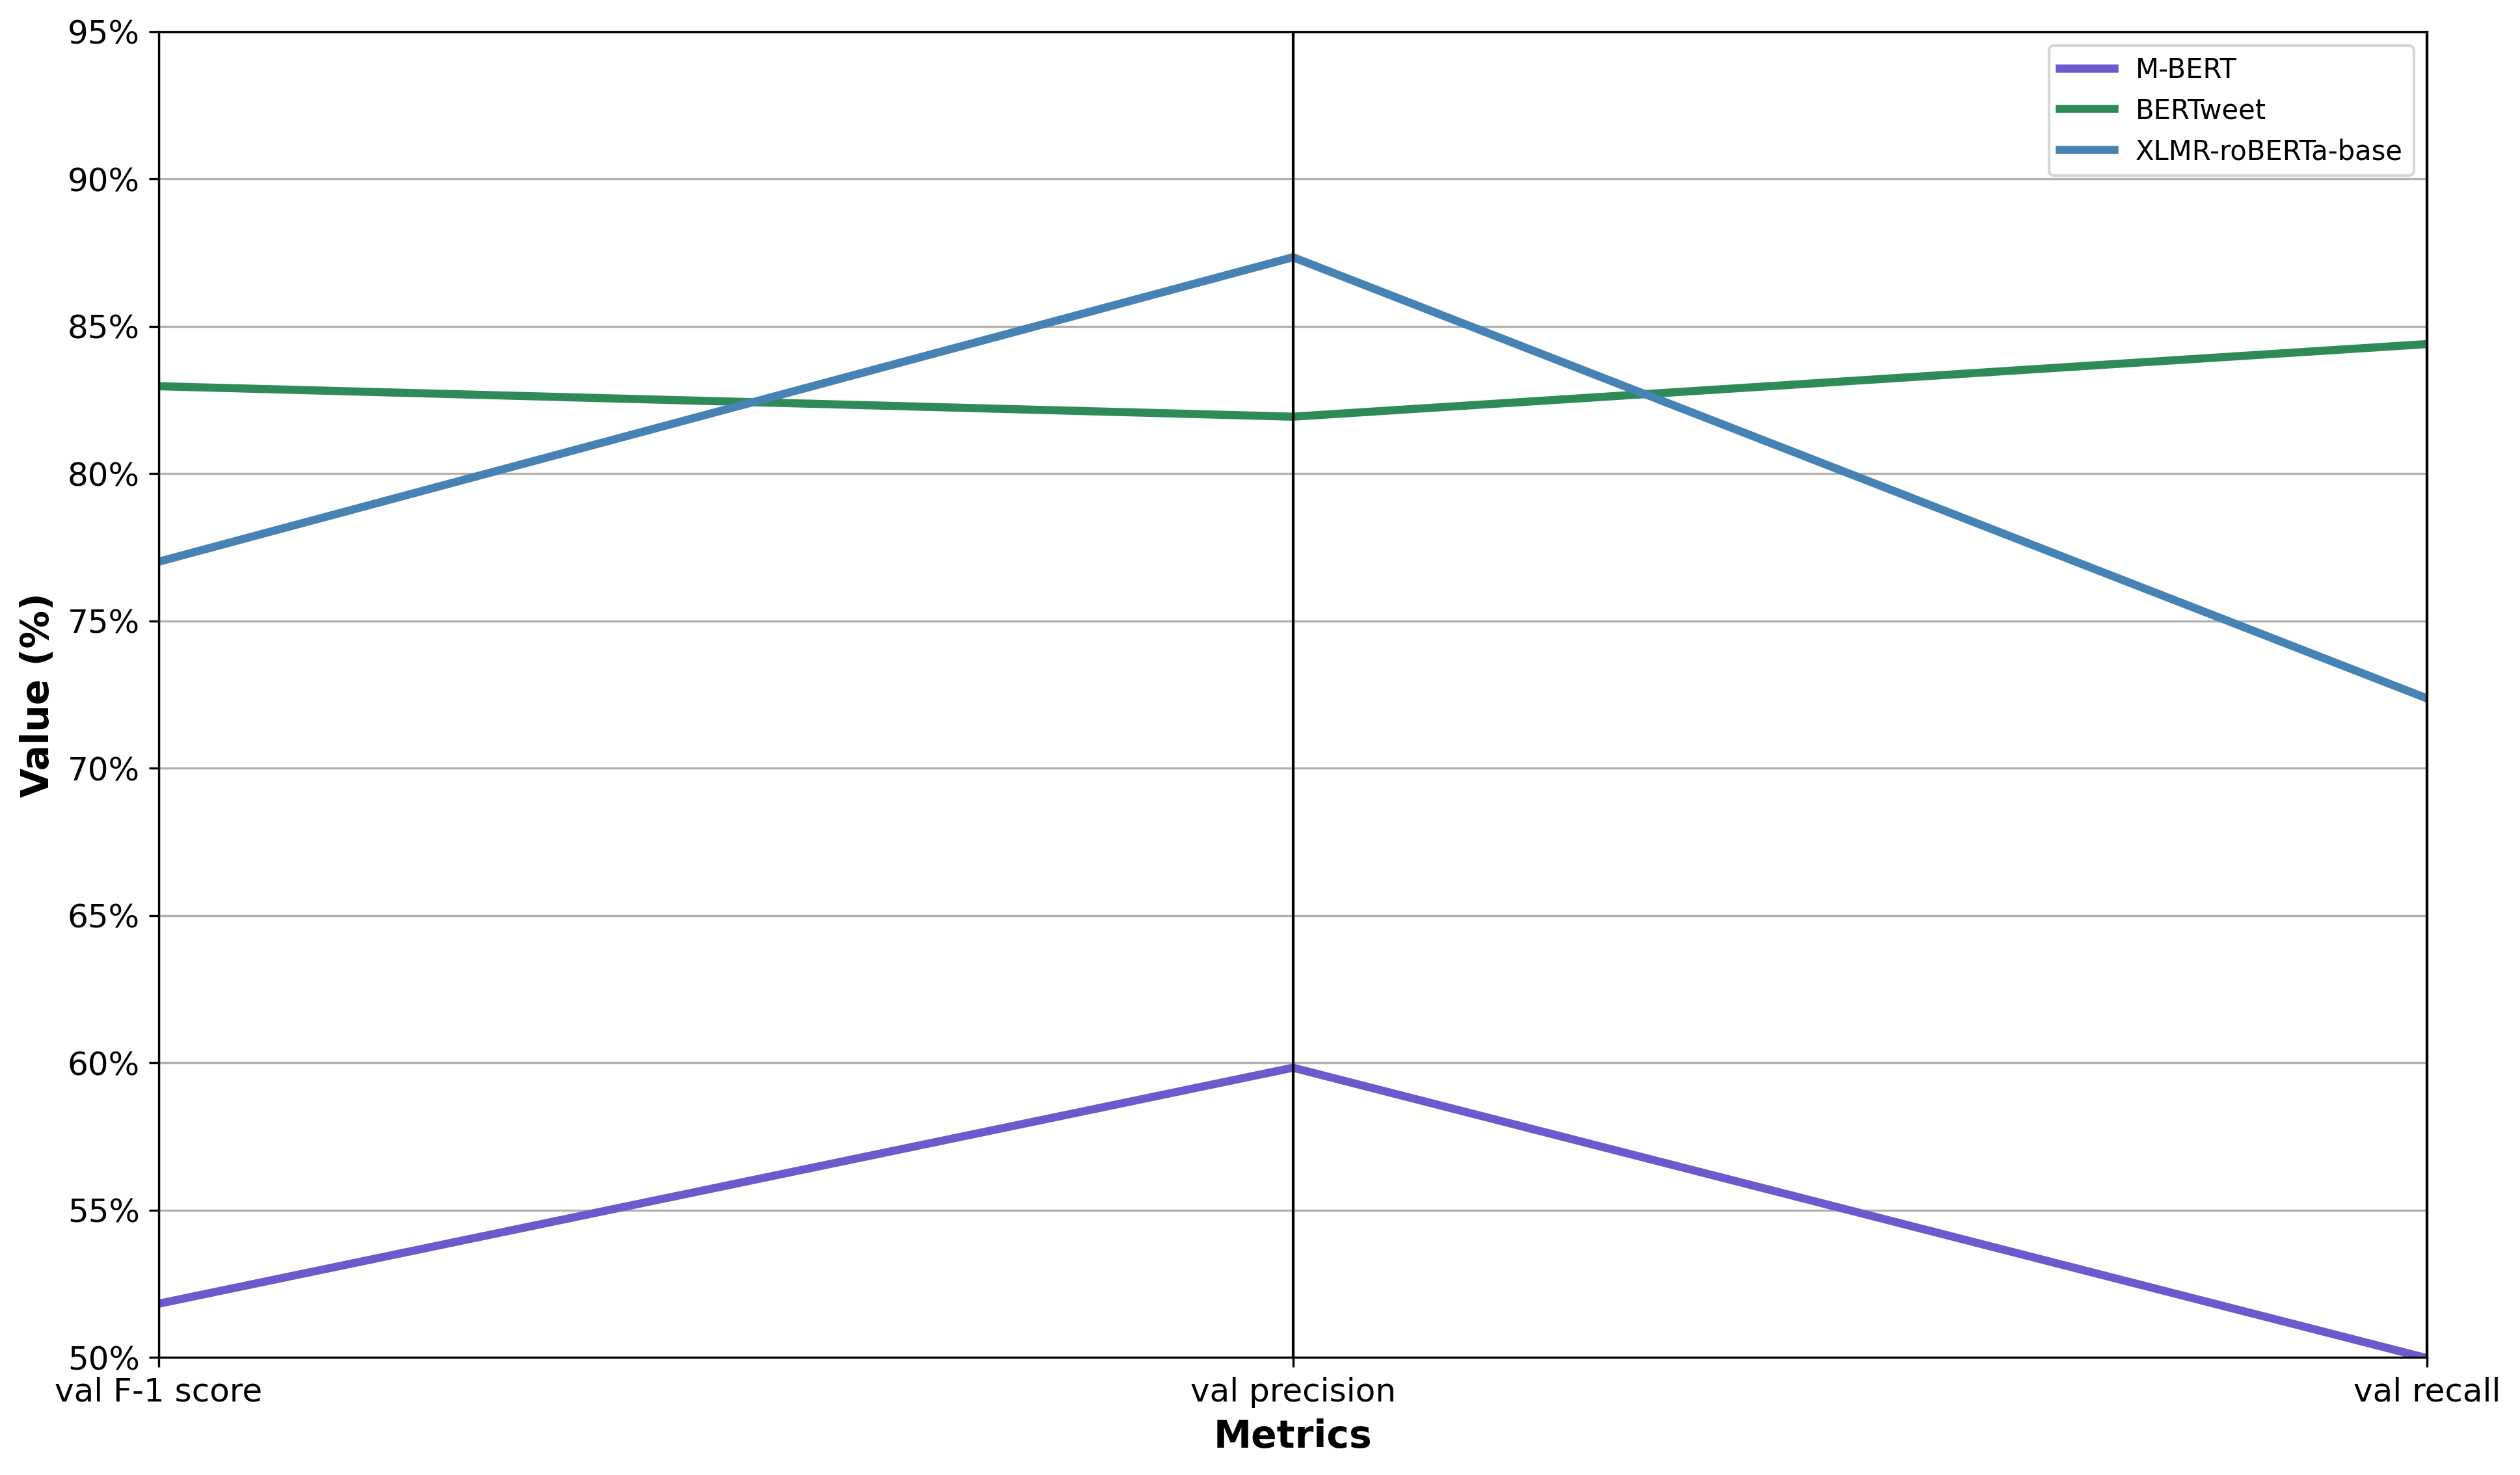

In [14]:
#Create plot
plt.figure(figsize=(15, 9), dpi=300)
parallel_coordinates(val_metrics,'model', linewidth=3, color=('slateblue','seagreen','steelblue')).set_ylim(0.5, 0.95)
plt.ylabel('Value (%)',fontsize=14, fontweight= 'bold')
plt.xlabel('Metrics',fontsize=14, fontweight= 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.show()

### 6. Use best model to predict on test set

In [15]:
# Prepare the test set
test_set_dataset = Generate_PyTorch_Dataset(
    texts        = test_df.Text.tolist(),
    labels       = test_df.label.tolist(),
    tokenizer    = bertweet_tokenizer
)

In [16]:
#Define training arguments for prediction mode
test_training_args = TrainingArguments(
output_dir = "../model_predictions",
do_predict = True
)

#Define the predictor
test_trainer = Trainer(
    model           = bertweet_model,
    args            = test_training_args,
    compute_metrics = compute_metrics,
)

#Predict on the validation set
test_preds = test_trainer.predict(test_set_dataset, metric_key_prefix='test')

test_results = [test_preds[-1]]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 76
  Batch size = 8


In [17]:
test_results_df = pd.DataFrame(test_results)

#Reformat names
test_results_df.columns = test_results_df.columns.str.replace('test_','test ').str.replace('_','-')

test_results_df

,test loss,test F-1 score,test precision,test recall,test runtime,test samples-per-second,test steps-per-second
0,0.702604,0.826302,0.849855,0.807304,20.1513,3.771,0.496


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


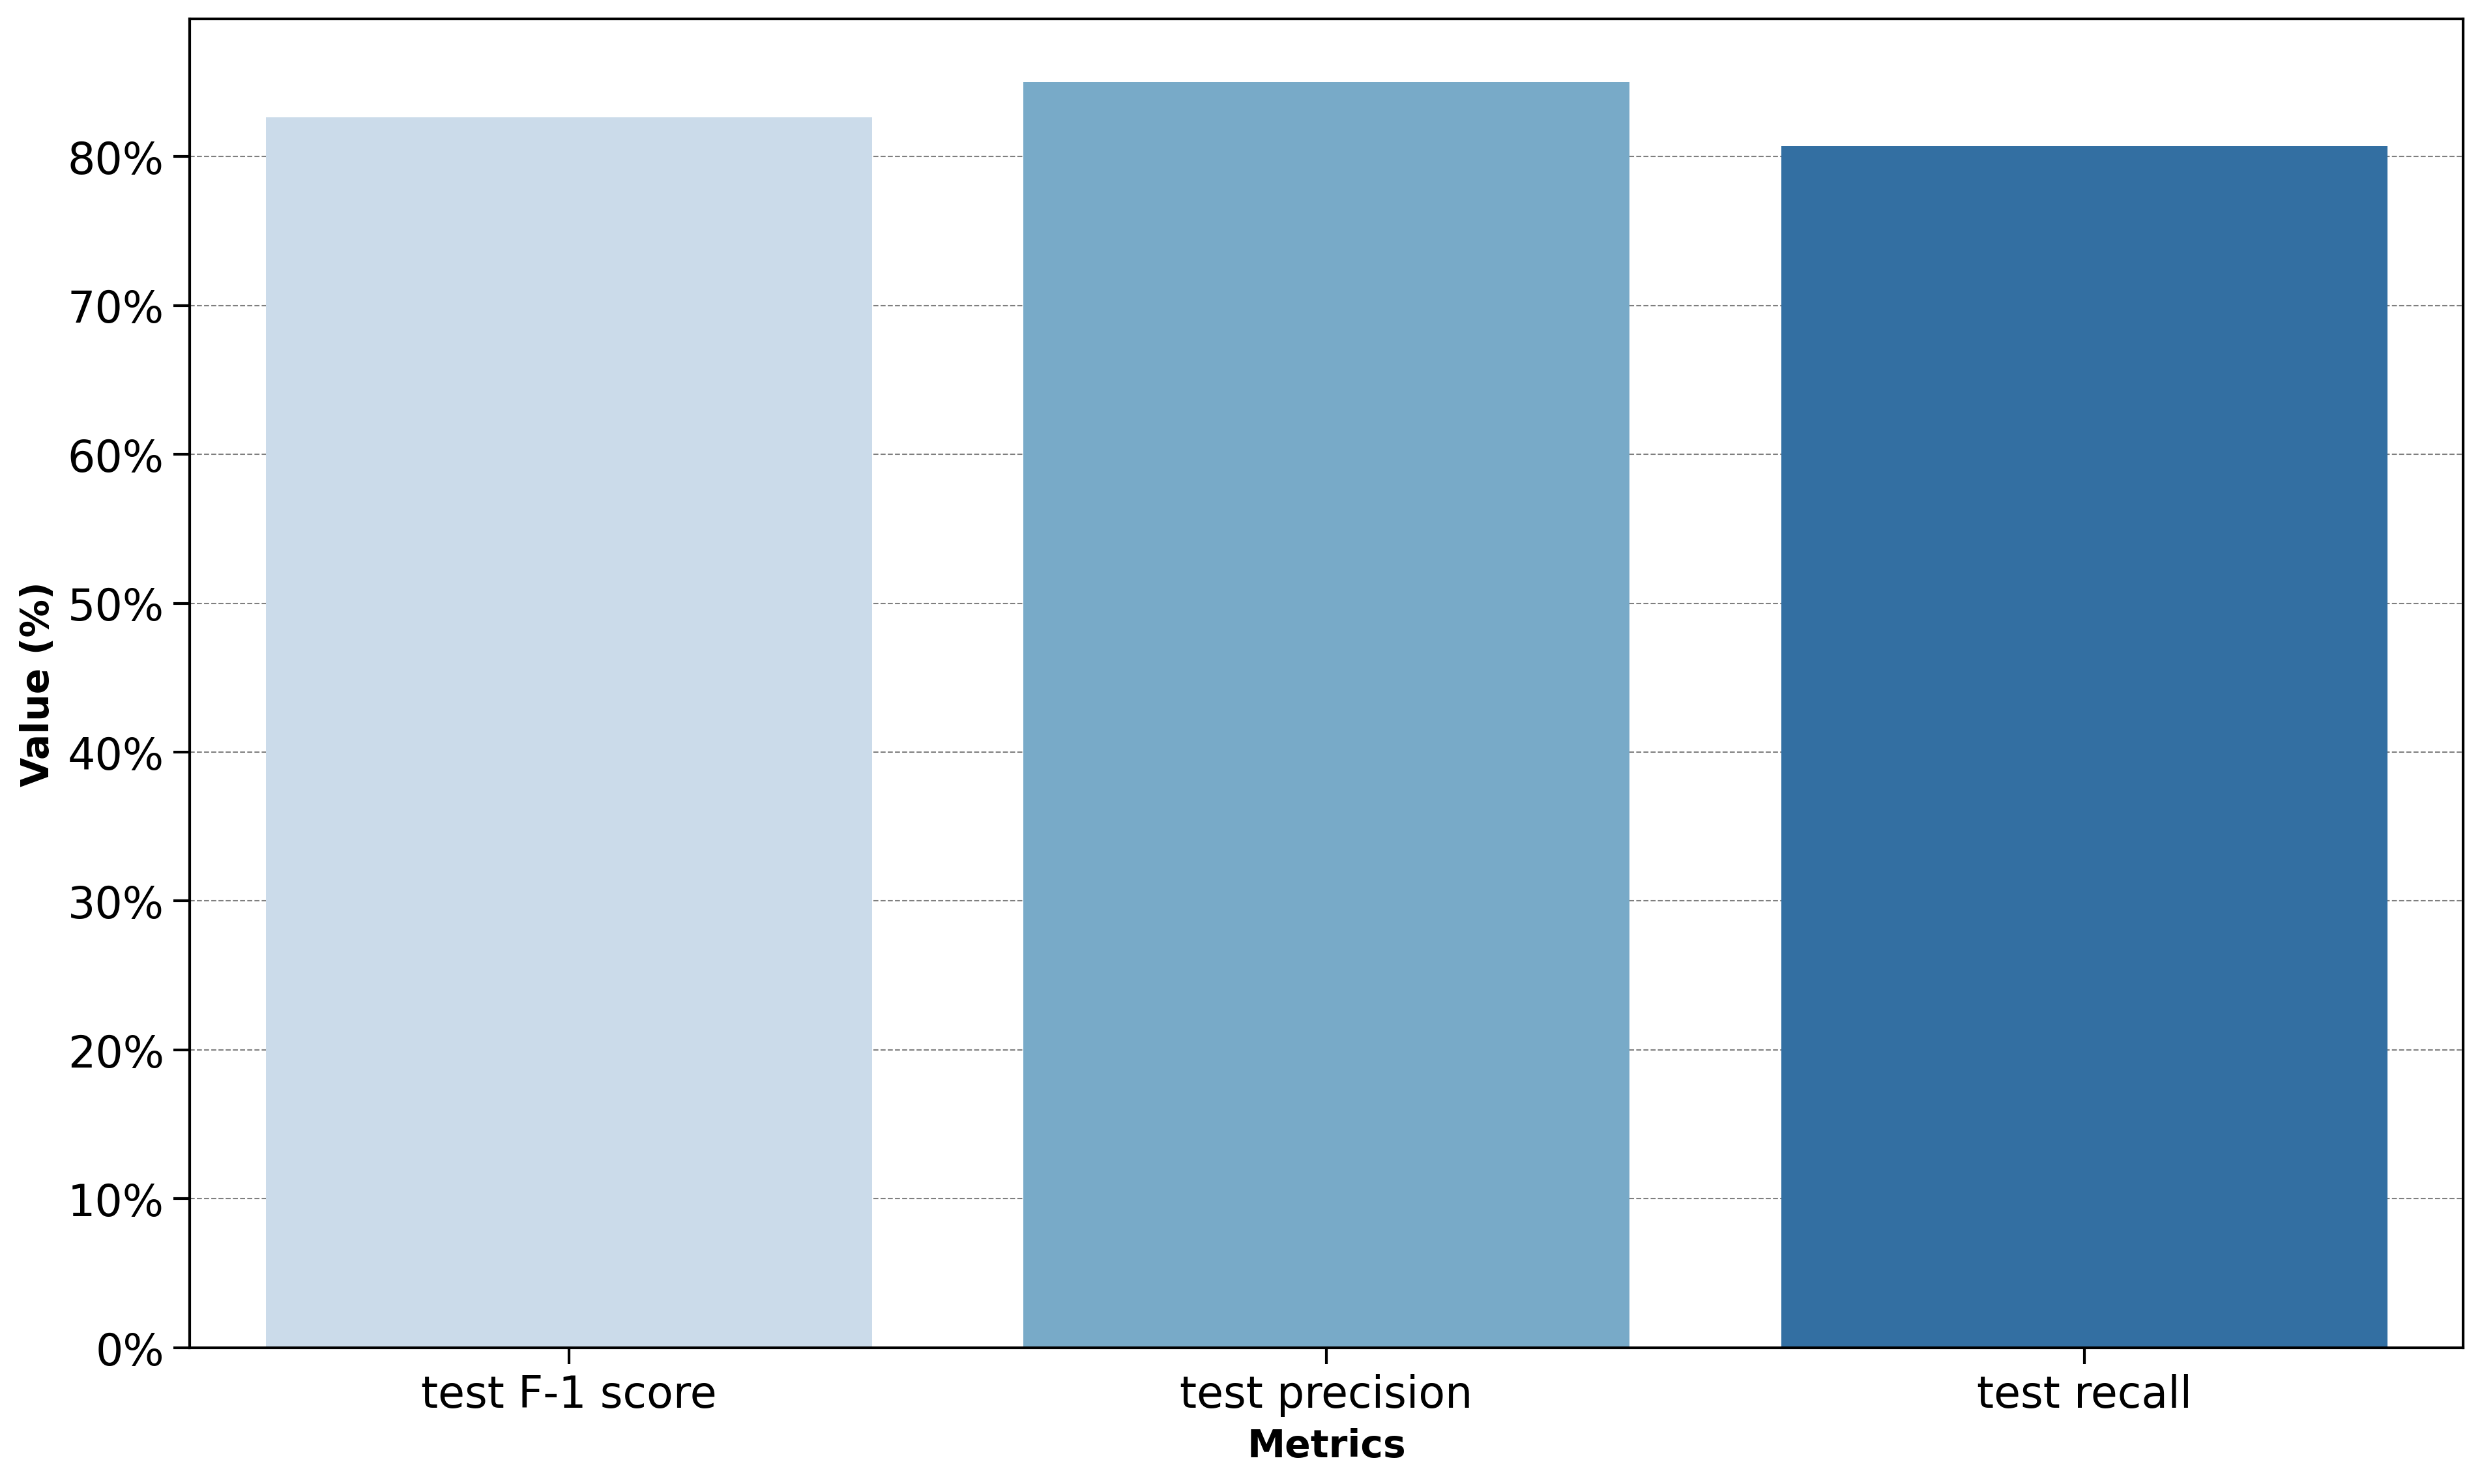

In [18]:
plt.figure(figsize=(15,9), dpi=300)
with plt.style.context(['notebook','no-latex','grid']):
    sns.barplot(data = test_results_df.iloc[:,1:4], palette = "Blues")
    plt.ylabel('Value (%)',fontsize=14, fontweight= 'bold')
    plt.xlabel('Metrics',fontsize=14, fontweight= 'bold')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()

### Combining both plots

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


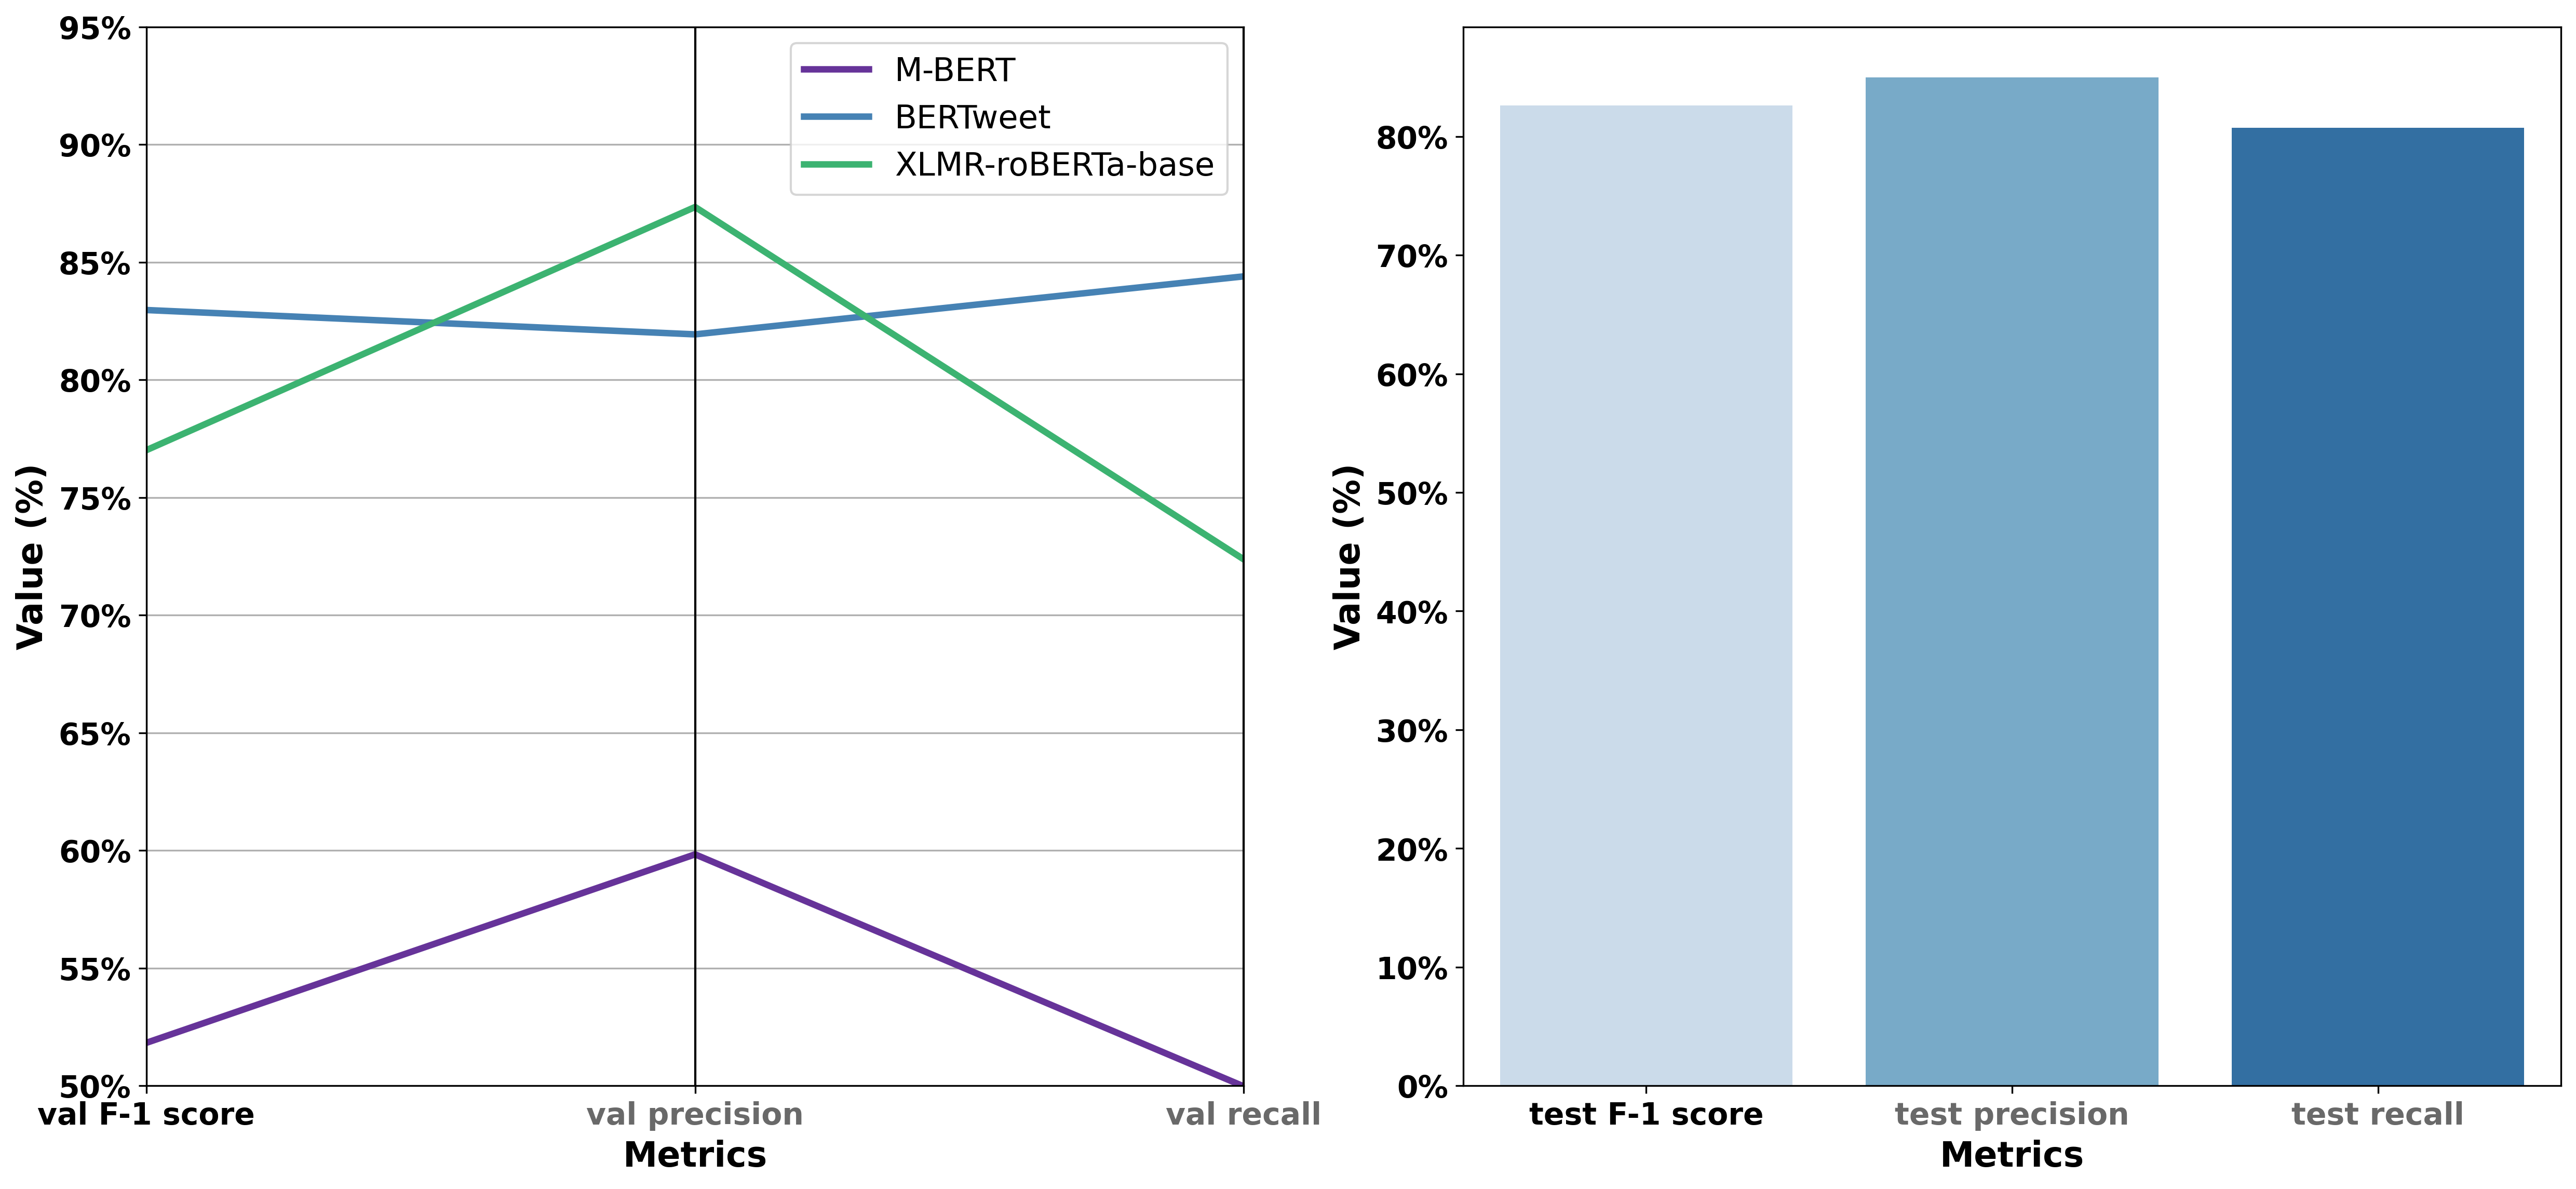

In [23]:
plt.figure(figsize=(20,9), dpi=300)

plt.subplot(1,2,1)
#Create plot
parallel_coordinates(val_metrics,'model', 
                     linewidth=3, 
                     color=('rebeccapurple','steelblue','mediumseagreen')).set_ylim(0.5, 0.95)
plt.ylabel('Value (%)',fontsize=16, fontweight= 'bold')
plt.xlabel('Metrics',fontsize=16, fontweight= 'bold')
plt.xticks(fontsize = 14, fontweight= 'semibold')
plt.yticks(fontsize = 14, fontweight= 'semibold')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.gca().tick_params(axis='x', labelcolor='dimgray')
plt.gca().get_xticklabels()[0].set_color('black')
plt.legend(prop={'size': 15})

plt.subplot(1,2,2)
with plt.style.context(['notebook','no-latex','grid']):
    sns.barplot(data = test_results_df.iloc[:,1:4], palette = "Blues")
    plt.ylabel('Value (%)',fontsize=16, fontweight= 'bold')
    plt.xlabel('Metrics',fontsize=16, fontweight= 'bold')
    plt.xticks(fontsize = 14, fontweight= 'semibold')
    plt.yticks(fontsize = 14, fontweight= 'semibold')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.gca().tick_params(axis='x', labelcolor='dimgray')
    plt.gca().get_xticklabels()[0].set_color('black')
    plt.show()